# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.



# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**The problem**

That I chose to solve was to build a model that predicts whether a customer will respond to an offer. My strategy for solving this problem has two steps. First, I will combine the offer portfolio, customer profile, and transaction data. Each row of this combined dataset will describe an offer's attributes, customer demographic data, and whether the offer was successful. Second, I will use  the LinearRegression model. This provides me with a baseline for evaluating the performance of models that I construct. Accuracy measures how well a model correctly predicts whether an offer is successful.


# Import library

In [1]:
# library
import re
import math
import json
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression

% matplotlib inline

# Import Data

In [2]:
#Import data
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

#  Portfolio Data


In [3]:
# Check portfolio data
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [4]:
# Check columns in portfolio 
portfolio.columns

Index(['channels', 'difficulty', 'duration', 'id', 'offer_type', 'reward'], dtype='object')

In [5]:
#Check portfolio info 
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [6]:
# view the shape of dateset
portfolio.shape

(10, 6)

In [7]:
# view the unique for difficulty
portfolio.difficulty.unique()

array([10,  0,  5, 20,  7])

In [8]:
# view the unique for duration
portfolio.duration.unique()

array([ 7,  5,  4, 10,  3])

In [9]:
# view the unique for reward
portfolio.reward.unique()

array([10,  0,  5,  3,  2])

In [10]:
# view the unique for offer_type
portfolio.offer_type.unique()

array(['bogo', 'informational', 'discount'], dtype=object)

In [11]:
# count the number of offer by offer type
offer_type_count=portfolio.groupby('offer_type').id.count()

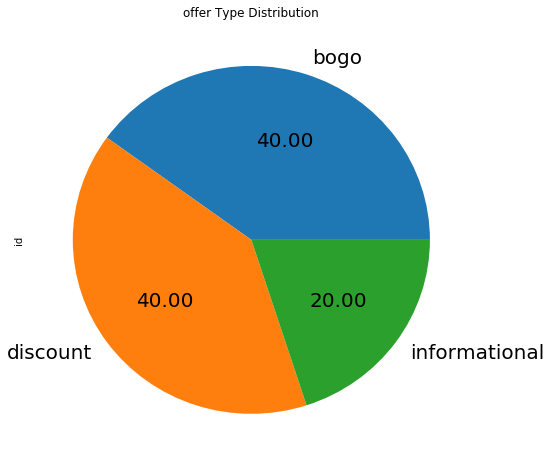

In [12]:
#offer Type Distribution
offer_type_count.plot.pie(figsize=(8, 8), fontsize = 20, autopct = '%.2f', title = 'offer Type Distribution');

We have three types of offers , BOGO and discount used more than informational 

In [13]:
portfolio.describe()

,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


# Clean Portfolio Data

In [14]:
# Check portfolio data
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [15]:
# null in dataset
portfolio.isnull().sum()

channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64

In [16]:
#change duration to hour
portfolio.duration = portfolio.duration*24

In [17]:
# rename id to offer_id.
portfolio.rename(columns={'id': 'offer_id'}, inplace=True)

In [18]:
# Check portfolio data
portfolio.head()

,channels,difficulty,duration,offer_id,offer_type,reward
0,"[email, mobile, social]",10,168,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,120,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,96,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,240,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


#  Profile Data


In [19]:
# Check profile data
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [20]:
#Check portfolio info 
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [21]:
# Check columns in profile 
profile.columns

Index(['age', 'became_member_on', 'gender', 'id', 'income'], dtype='object')

In [22]:
# view the shape of dateset
profile.shape

(17000, 5)

In [23]:
# view the unique for age
profile.age.unique()

array([118,  55,  75,  68,  65,  58,  61,  26,  62,  49,  57,  40,  64,
        78,  42,  56,  33,  46,  59,  67,  53,  22,  96,  69,  20,  45,
        54,  39,  41,  79,  66,  29,  44,  63,  36,  76,  77,  30,  51,
        27,  73,  74,  70,  89,  50,  90,  60,  19,  72,  52,  18,  71,
        83,  43,  47,  32,  38,  34,  85,  48,  35,  82,  21,  24,  81,
        25,  37,  23, 100,  28,  84,  80,  87,  86,  94,  31,  88,  95,
        93,  91,  92,  98, 101,  97,  99])

In [24]:
# view the avg for age
avg_age=profile.age.mean()

In [25]:
avg_age

62.531411764705879

In [26]:
# view the avg for income
avg_income=profile.income.mean()

In [27]:
avg_income

65404.991568296799

In [28]:
# No of users
users=profile.id.nunique()

In [29]:
users

17000

In [30]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [31]:
# count gender value
gender_count=profile.gender.value_counts()

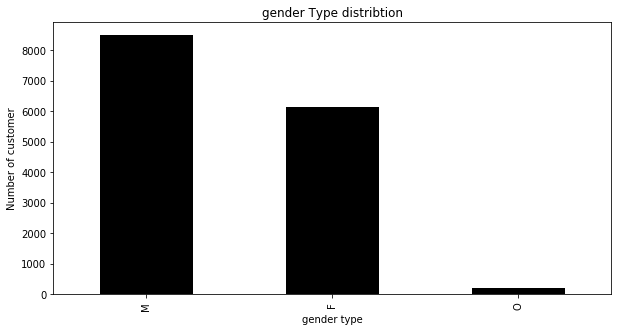

In [32]:
gender_count.plot.bar(color = 'black', figsize =(10,5), title = 'gender Type distribtion')
plt.xlabel('gender type');
plt.ylabel('Number of customer');

the male customer more than female and other

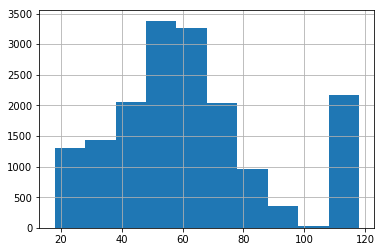

In [33]:
# age distribution
profile.age.hist();

 118 unnormal distribution

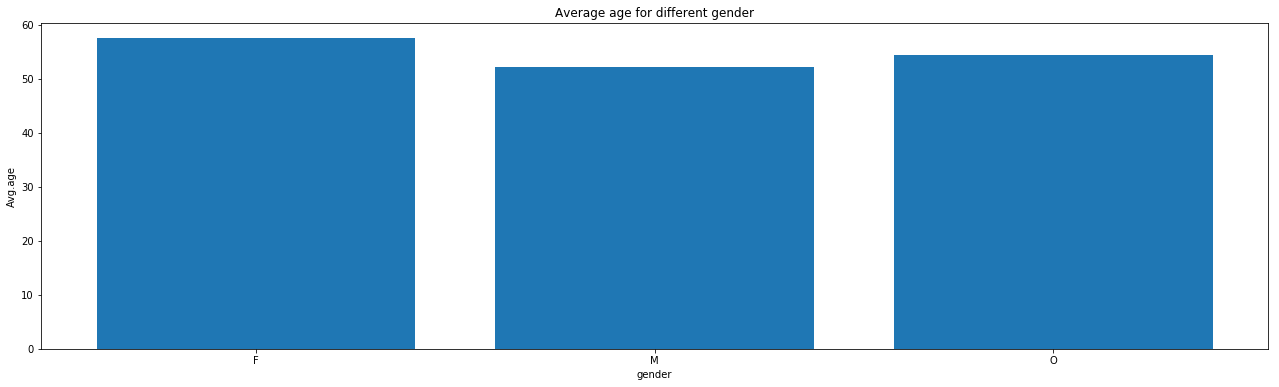

In [34]:
# Check the Average age for different gender
age_gender = profile.groupby('gender')['age'].mean().sort_values(ascending = False)

# Plot the Average age for different gender
plt.figure(figsize=[22,6]);
plt.bar(age_gender.index, age_gender);
plt.xlabel('gender');
plt.ylabel('Avg.age');
plt.title('Average age for different gender');

 Mean age in F customers are older than M and O customers

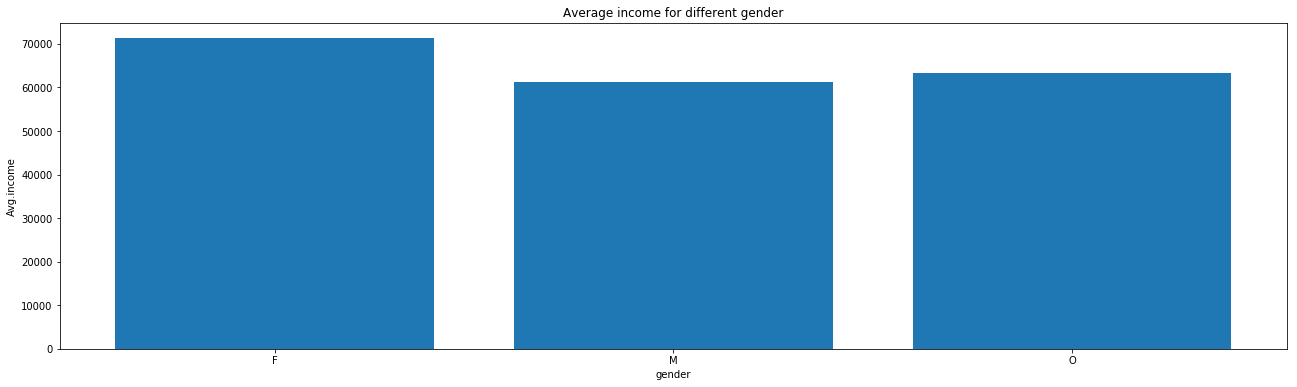

In [35]:
# Check the Average income for different gender
income_gender = profile.groupby('gender')['income'].mean().sort_values(ascending = False)

# Plot the Average income for different gender
plt.figure(figsize=[22,6]);
plt.bar(age_gender.index, income_gender);
plt.xlabel('gender');
plt.ylabel('Avg.income');
plt.title('Average income for different gender');

 Mean income in F customers are more than M and O customers

# Clean Profile Data

In [36]:
# Remove null income data
profile = profile[profile['income'].notnull()]

# Change the name of the id to user_id
profile.rename(columns={'id': 'user_id'}, inplace=True)
    
# Date format for became_member_on.
profile.became_member_on = profile['became_member_on'].astype(str).astype('datetime64[ns]', format = "%Y%m%d")
    
profile.dropna(subset=['gender', 'income'], inplace = True)
profile.drop(profile[profile.age == 118].index, inplace = True)

In [37]:
# add start_year , start_month , start_day columns
profile['start_year'] = profile.became_member_on.dt.year
profile["start_month"] = profile.became_member_on.dt.month
profile["start_day"] = profile.became_member_on.dt.day

In [38]:
# change gender to 0 and 1 to use it in the model 
profile['gender'] = profile['gender'].apply(lambda x: 1 if x == 'M' else 0)

In [39]:
profile.head()

,age,became_member_on,gender,user_id,income,start_year,start_month,start_day
1,55,2017-07-15,0,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,15
3,75,2017-05-09,0,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,5,9
5,68,2018-04-26,1,e2127556f4f64592b11af22de27a7932,70000.0,2018,4,26
8,65,2018-02-09,1,389bc3fa690240e798340f5a15918d5c,53000.0,2018,2,9
12,58,2017-11-11,1,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017,11,11


In [40]:
# check null value
profile.isnull().sum()

age                 0
became_member_on    0
gender              0
user_id             0
income              0
start_year          0
start_month         0
start_day           0
dtype: int64

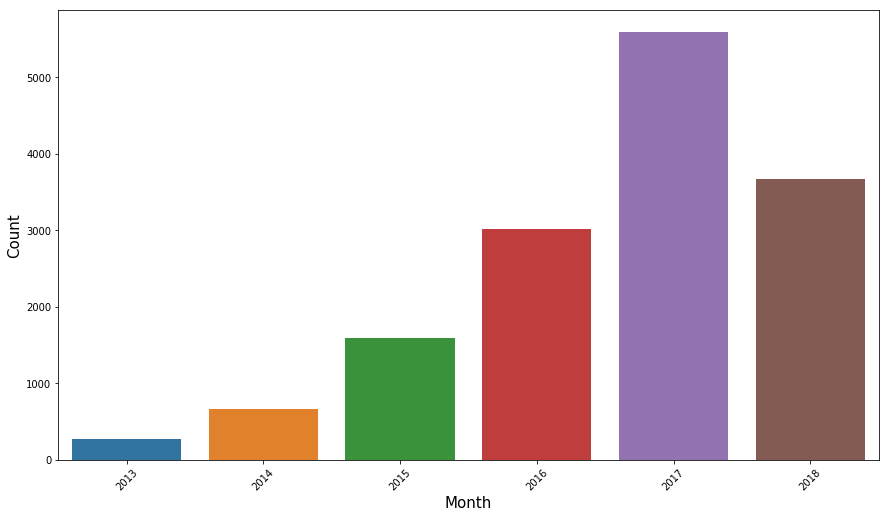

In [41]:
# start year and #customers
plt.figure(figsize=(14.70, 8.27)) 
sns.countplot(data= profile, x= 'start_year')
plt.xlabel('Month',fontsize= 15)
plt.ylabel('Count',fontsize= 15);
plt.xticks(rotation=45); 

The most customers joined the Starbucks in 2017.

# Transcript dataset


In [42]:
# Check transcript data
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [43]:
#Check transcript info 
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [44]:
# Check columns in transcript 
transcript.columns

Index(['event', 'person', 'time', 'value'], dtype='object')

In [45]:
# view the shape of transcript
transcript.shape

(306534, 4)

In [46]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [47]:
# view the unique for event
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'], dtype=object)

In [48]:
# check null value
transcript.isnull().sum()

event     0
person    0
time      0
value     0
dtype: int64

In [49]:
# count event value
event_count=transcript.event.value_counts()

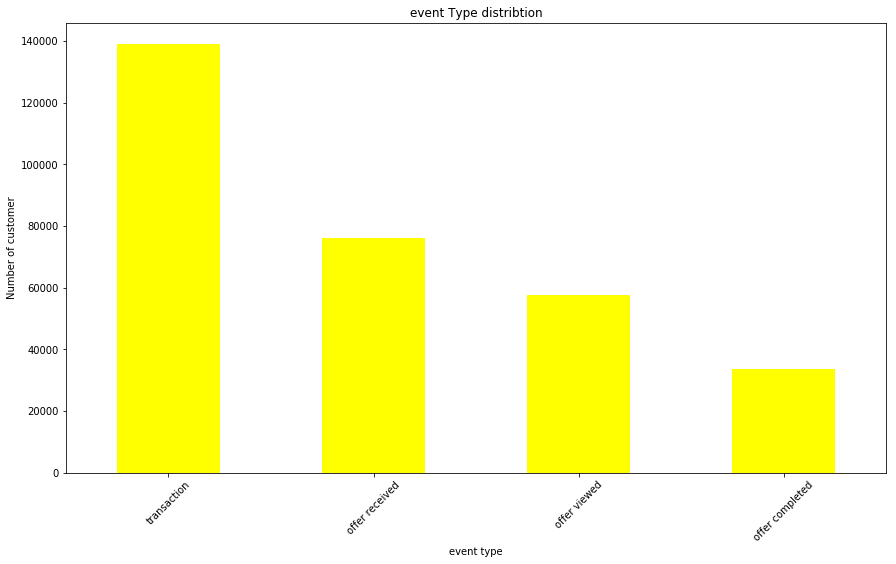

In [50]:
#Event type distribtion and #Customers
event_count.plot.bar(color = 'yellow', figsize=(14.70, 8.27), title = 'event Type distribtion')
plt.xlabel('event type');
plt.ylabel('Number of customer');
plt.xticks(rotation=45); 

There are 4 offer type customer received an offer, customer view an offer, customer perform a transaction, and customer complete an offer.


# Clean Transcript Data


In [51]:
def update_function (transcript):
    
    
    """Create  columns for amount, reward and offer_id
    update offer_id columm
    update amount,reword column  
    Change time column from hours to days
    Rename person column name to user_id.
    
  
       
    Returns:
    clean transcript
    
    """

    transcript.assign(amount='', reward='',offer_id='')
  
 
    for ndx, row in transcript.iterrows():
        for o in row['value']:
            if o == 'offer_id' or o == 'offer id':
                transcript.at[ndx, 'offer_id']= row['value'][o]
            if o == 'amount':
                transcript.at[ndx, 'amount']= row['value'][o]
            if o == 'reward':
                transcript.at[ndx, 'reward']= row['value'][o]

                  
   
    transcript['time'] = transcript['time']/24.
    

    transcript.rename(columns={'person': 'user_id'}, inplace=True)
    
    return transcript

In [52]:
# update transcript
transcript = update_function(transcript)

In [53]:
transcript.head()

,event,user_id,time,value,offer_id,amount,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0.0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0.0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0.0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0.0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0.0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN


In [54]:
transcript = transcript.drop('value', axis=1)
transcript.head()

,event,user_id,time,offer_id,amount,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0.0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0.0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN


In [55]:
# Print unique values in feature event
transcript['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'], dtype=object)

In [56]:
transcript = pd.get_dummies(transcript, columns=['event'], prefix = '', prefix_sep='')

In [57]:
transcript.head()

,user_id,time,offer_id,amount,reward,offer completed,offer received,offer viewed,transaction
0,78afa995795e4d85b5d9ceeca43f5fef,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,0,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,0.0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,0,1,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0.0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,0,1,0,0
4,68617ca6246f4fbc85e91a2a49552598,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,0,1,0,0


In [58]:
# sum all custumer's numeric data
transcript = transcript.groupby('user_id').sum().reset_index()

In [59]:
# drop transaction
transcript =  transcript.drop('transaction', axis = 1)

In [60]:
transcript.head()

,user_id,time,amount,reward,offer completed,offer received,offer viewed
0,0009655768c64bdeb2e877511632db8f,392.25,127.60,9.0,3,5,4
1,00116118485d4dfda04fdbaba9a87b5c,117.25,4.09,0.0,0,2,2
2,0011e0d4e6b944f998e987f904e8c1e5,273.75,79.46,13.0,3,5,5
3,0020c2b971eb4e9188eac86d93036a77,265.75,196.86,14.0,3,5,3
4,0020ccbbb6d84e358d3414a3ff76cffd,359.25,154.05,13.0,3,4,4


In [61]:
# Merge data
merge_data = pd.merge(  transcript, profile,  on = 'user_id', how = 'right')

In [62]:
merge_data

,user_id,time,amount,reward,offer completed,offer received,offer viewed,age,became_member_on,gender,income,start_year,start_month,start_day
0,0009655768c64bdeb2e877511632db8f,392.25,127.60,9.0,3,5,4,33,2017-04-21,1,72000.0,2017,4,21
1,0011e0d4e6b944f998e987f904e8c1e5,273.75,79.46,13.0,3,5,5,40,2018-01-09,0,57000.0,2018,1,9
2,0020c2b971eb4e9188eac86d93036a77,265.75,196.86,14.0,3,5,3,59,2016-03-04,0,90000.0,2016,3,4
3,0020ccbbb6d84e358d3414a3ff76cffd,359.25,154.05,13.0,3,4,4,24,2016-11-11,0,60000.0,2016,11,11
4,003d66b6608740288d6cc97a6903f4f0,488.25,48.34,9.0,3,5,4,26,2017-06-21,0,73000.0,2017,6,21
5,00426fe3ffde4c6b9cb9ad6d077a13ea,271.00,68.51,2.0,1,5,2,19,2016-08-09,0,65000.0,2016,8,9
6,004b041fbfe44859945daa2c7f79ee64,247.00,138.36,7.0,2,3,2,55,2018-05-08,0,74000.0,2018,5,8
7,004c5799adbf42868b9cff0396190900,469.50,347.38,24.0,5,5,4,54,2016-03-31,1,99000.0,2016,3,31
8,005500a7188546ff8a767329a2f7c76a,195.75,20.36,5.0,1,5,3,56,2017-12-09,1,47000.0,2017,12,9
9,0056df74b63b4298809f0b375a304cf4,257.00,144.14,13.0,3,4,3,54,2016-08-21,1,91000.0,2016,8,21


# Modeling data

In [63]:
model_data= merge_data[['time', 'offer completed', 'amount', 'reward','age' , 'gender' , 'income']]

In [64]:
model_data

,time,offer completed,amount,reward,age,gender,income
0,392.25,3,127.60,9.0,33,1,72000.0
1,273.75,3,79.46,13.0,40,0,57000.0
2,265.75,3,196.86,14.0,59,0,90000.0
3,359.25,3,154.05,13.0,24,0,60000.0
4,488.25,3,48.34,9.0,26,0,73000.0
5,271.00,1,68.51,2.0,19,0,65000.0
6,247.00,2,138.36,7.0,55,0,74000.0
7,469.50,5,347.38,24.0,54,1,99000.0
8,195.75,1,20.36,5.0,56,1,47000.0
9,257.00,3,144.14,13.0,54,1,91000.0


In [65]:
model_data.isnull().sum()

time               0
offer completed    0
amount             0
reward             0
age                0
gender             0
income             0
dtype: int64

In [66]:
X = model_data[['time', 'amount', 'reward', 'age', 'gender', 'income']]
y = model_data['offer completed']

In [67]:
sc = MinMaxScaler()
to_norm = ['time', 'amount', 'reward', 'age', 'gender', 'income']

X[to_norm] = sc.fit_transform(X[to_norm])
X.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,time,amount,reward,age,gender,income
0,0.438988,0.079319,0.163636,0.180723,1.0,0.466667
1,0.296174,0.049394,0.236364,0.265060,0.0,0.300000
2,0.286532,0.122373,0.254545,0.493976,0.0,0.666667
3,0.399217,0.095761,0.236364,0.072289,0.0,0.333333
4,0.554685,0.030049,0.163636,0.096386,0.0,0.477778


In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# LinearRegression

In [69]:
from sklearn.metrics import mean_squared_error, r2_score

In [79]:
# LinearRegression
lm_model = LinearRegression(normalize=True)
# Fit the model 
lm_model.fit(X_train, y_train)
# Pred
pred_score = lm_model.predict(X_test)
# Check the score 
r2_score(y_test, pred_score)

0.83298262404617518

# DecisionTreeClassifier


In [94]:
from sklearn.tree import DecisionTreeClassifier

#DecisionTreeClassifier()
dtc = DecisionTreeClassifier()
#Fit the model
dtc.fit(X_train, y_train)
#Pred
pred_score = dtc.predict(X_test)
print('Accuracy {}'.format(accuracy_score(y_test, pred_score)))

Accuracy 0.6768276234151606


# Models Results 

In [110]:
models = [dtc, lm_model ]
model_names = [type(n).__name__ for n in models]
models_accuracy = [x1.score(X_train, y_train)*100 for x1 in models]
bogo_test_accuracy = [y1.score(X_test,y_test)*100 for y1 in models]

In [117]:
results = [models_accuracy,bogo_test_accuracy]
results_df = pd.DataFrame(results, columns = model_names,index=['Training Accuracy', 'Test Accuracy'])
results_df

,DecisionTreeClassifier,LinearRegression
Training Accuracy,100.000000,83.200169
Test Accuracy,67.682762,83.298262


suggests that the resulting DecisionTreeClassifier model has a training data accuracy of 100 and test accuracy of 67. i think that the DecisionTreeClassifier model I think did not overfit the training data.To avoid overfitting I will choose LinearRegression since it got better results 83% on training and 83.3% on testing datasets. LinearRegression is better used here since we have few binomial outcomes

# improve the Algorithm

In [132]:
# Referance https://scikit-learn.org/stable/modules/grid_search.html

from sklearn.model_selection import GridSearchCV

#The DecisionTreeClassifier()
Dectree = DecisionTreeClassifier()

#The parameters
pm =  {'min_samples_split' : range(20,400,40),'max_depth': range(3,40,5)}

#The GridSearchCV
gobj = GridSearchCV(Dectree, pm)
gfit = gobj.fit(X_train, y_train)
grid = GridSearchCV(estimator=Dectree, param_grid=pm,cv=5)
grid_result = grid.fit(X_train, y_train)

# The Estimatr
bclf = gfit.best_estimator_

# The predict
pred = (Dectree.fit(X_train, y_train)).predict(X_test)
bpred = bclf.predict(X_test)

# Accuracy score on testing data and Final accuracy score on the testing data
print("Accuracy score: {:.4f}".format(accuracy_score(y_test, pred)))
print("Final accuracy score: {:.4f}".format(accuracy_score(y_test, bpred)))
print(f'Best params: {grid_result.best_params_}')

Accuracy score: 0.6771
Final accuracy score: 0.7189
Best params: {'max_depth': 13, 'min_samples_split': 140}


i used GridSearchCV to improve the DecisionTreeClassifier model and I get 71% increased by 4.9% and I think it doesn't need further improvements and LinearRegression is 83% it is better than DecisionTreeClassifier I will choose LinearRegression and Best params: {'max_depth': 13, 'min_samples_split': 140}

# Conclusion

The goal of this project is to predict how the customer will interact with the offers that Starbuck will present/send. Firstly I took the provided data that requires some cleaning activity, then I did the needed changes to analyze that data that required to be applied before starting the data exploring activity. Finally, I used two models first one DecisionTreeClassifier I got 67% and the second one I use the LinearRegression I got 83% accuracy rate. I used GridSearchCV to improve the DecisionTreeClassifier model and I get 71% increased by 4.9% and I think it doesn't need further improvements. As a result of modeling the data, we found the females are more excited about the offer, and Starbuck should enhance their offers based on the provided result. Moreover, Starbuck can use the model to enhance their offers periodically after each offer to know the real benefits to aim their offer to the correct audience

# challenge
The challenging part is what the problem I will solve and how to improve the model, I very enjoy working on this project.I will build many models to help my company

# Improvements
I think I arrive at a good point. To make the result better, I will try to improve the data gathering and fix nulls values. I will also try to get more data about customers and products. I think if we have more attributes it is will be perfect 